## Deep Learning

Deep Learning myths:
- Needs lots of math
- Needs lots of data
- Needs lots of expensive computers

Books:
- ["Meta Learning: How To Learn Deep Learning And Thrive In The Digital World"](https://rosmulski.gumroad.com/l/learn_machine_learning?_gl=1*3lzvdd*_ga*MTU0Mjc0Mzg5LjE3NjA5ODgxMzU.*_ga_6LJN6D94N6*czE3NjE5MzI3NDgkbzUkZzAkdDE3NjE5MzI3NDgkajYwJGwwJGgw) by Radek Osmulski
- ["A Mathematician's Lament"](https://eva.fcien.udelar.edu.uy/pluginfile.php/129978/mod_resource/content/2/A%20Mathematicians%20Lament.pdf) by Paul Lockhart - describes a different way of learning  

<img src="../images/mathematicans_lament.png" alt="A Mathematician's Lament" width="100"/>

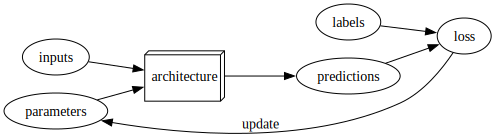

In [16]:
from graphviz import Source

def gv(s): return Source('digraph G{ rankdir=LR ' + s + '; }')

gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

### Vocabulary

| Term | Meaning |
|------|---------|
| Label | The data that we're trying to predict, such as "dog" or "cat" |
| Architecture | The _template_ of the model that we're trying to fit; the actual mathematical function that we're passing the input data and parameters to |
| Model | The combination of the architecture with a particular set of parameters |
| Parameters | The values in the model that change what task it can do, and are updated through model training |
| Fit | Update the parameters of the model such that the predictions of the model using the input data match the target labels |
| Train | A synonym for _fit_ |
| Pretrained model | A model that has already been trained, generally using a large dataset, and will be fine-tuned |
| Fine-tune | Update a pretrained model for a different task |
| Epoch | One complete pass through the input data |
| Loss | A measure of how good the model is, chosen to drive training via SGD |
| Metric | A measurement of how good the model is, using the validation set, chosen for human consumption |
| Validation set | A set of data held out from training, used only for measuring how good the model is |
| Training set | The data used for fitting the model; does not include any data from the validation set |
| Overfitting | Training a model in such a way that it _remembers_ specific features of the input data, rather than generalizing well to data not seen during training |
| CNN | Convolutional neural network; a type of neural network that works particularly well for computer vision tasks |

## Image Classifier - Pets

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

# takes ~ 6 mins locally

epoch,train_loss,valid_loss,error_rate,time
0,0.167516,0.027117,0.010825,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.054816,0.015526,0.003383,00:59


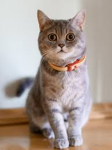

In [6]:
img_cat = PILImage.create("../images/cat.jpeg")
img_cat.to_thumb(150)

In [7]:
is_cat, _, probs = learn.predict(img_cat)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000


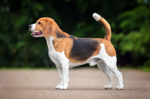

In [8]:
img_dog = PILImage.create("../images/dog.webp")
img_dog.to_thumb(150)

In [9]:
is_cat, _, probs = learn.predict(img_dog)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.000186


## Image Segmentation - Road Camera

In [18]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.557631,2.176956,00:06


epoch,train_loss,valid_loss,time
0,1.746039,1.427293,00:01
1,1.523737,1.266171,00:01
2,1.467321,1.485658,00:01
3,1.421688,1.172307,00:01
4,1.322547,1.039921,00:01
5,1.225800,0.969248,00:01
6,1.139347,0.925257,00:01
7,1.069614,0.916164,00:01


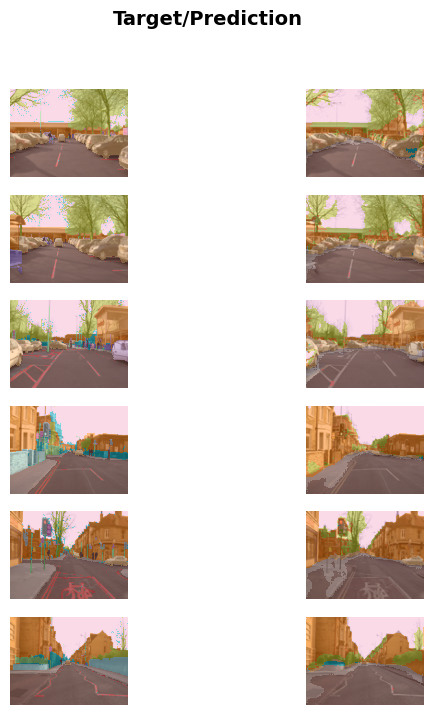

In [19]:
learn.show_results(max_n=6, figsize=(7,8))

## Text Classification - IMDB

In [22]:
from fastai.text.all import *

path = untar_data(URLs.IMDB)
dls = TextDataLoaders.from_folder(path, valid='test')

learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

# Goes out of memory locally!

KeyboardInterrupt: 

In [ ]:
learn.predict("I really liked that movie!")

## Tabular Data Classifier - Adult Income

In [23]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(3)

/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


epoch,train_loss,valid_loss,accuracy,time
0,0.370046,0.376860,0.824017,00:05
1,0.349754,0.370398,0.826167,00:03
2,0.349689,0.369861,0.829238,00:03


## Collaborative Filtering - Movie Recommendations

In [24]:
from fastai.collab import *

path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.479332,1.354198,00:01


epoch,train_loss,valid_loss,time
0,1.364292,1.299822,00:00
1,1.297438,1.142860,00:00
2,1.057350,0.873061,00:00
3,0.810186,0.741575,00:00
4,0.671871,0.715253,00:00
5,0.641159,0.707319,00:00
6,0.612701,0.703163,00:00
7,0.588274,0.703106,00:00
8,0.588961,0.702437,00:00
9,0.614220,0.702292,00:00


In [25]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,41.0,71.0,4.0,4.011631
1,64.0,20.0,1.5,4.122751
2,91.0,5.0,4.0,3.243315
3,77.0,25.0,4.0,3.535184
4,20.0,30.0,1.5,3.237961
5,14.0,46.0,2.5,3.097747
6,47.0,80.0,4.5,4.481868
7,89.0,49.0,4.0,4.016407
8,94.0,45.0,3.5,4.238504


## Image Classifier - Coffee Types

In [46]:
from ddgs import DDGS
from fastdownload import download_url
from fastai.vision.all import *


def search_images(keywords, max_images=200):
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

def download_and_show_image(keywords, path=Path('../images/')):
  urls = search_images(keywords, max_images=1)
  dest = path + keywords + '.jpg'
  download_url(urls[0], dest, show_progress=False)

  im = Image.open(dest)
  return im.to_thumb(256,256)

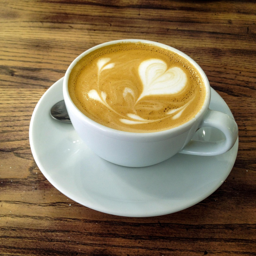

In [42]:
download_and_show_image('coffee latte')

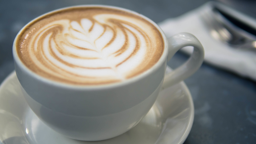

In [43]:
download_and_show_image('coffee capuccino')

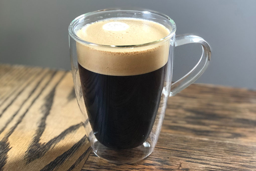

In [44]:
download_and_show_image('coffee americano')

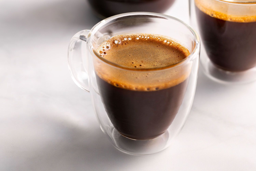

In [45]:
download_and_show_image('coffee espresso')

In [65]:
searches = 'coffee latte cup', 'coffee capuccino cup', 'coffee americano cup', 'coffee espresso cup'
labels = 'latte', 'capuccino', 'americano', 'espresso'
path = Path('../../data/raw/coffees')

for i in range(len(searches)):
    dest = (path/labels[i])
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{searches[i]} photo'))
    time.sleep(5)
    resize_images(path/labels[i], max_size=400, dest=path/labels[i])

/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork

In [66]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork

0

To turn data into a `DataLoaders` object, fastai needs to know at least four things:

- Kinds of data
- How to get the list of items
- How to label these items
- How to create the validation set

We don't feed the model one image at a time but several of them (what we call a **mini-batch**).  
To group them in a big array (usually called a **tensor**) that is going to go through our model, they all need to be of the *same size*.

The **independent variable** is the thing we are using to make predictions from, and the **dependent variable** is the target.

/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: De

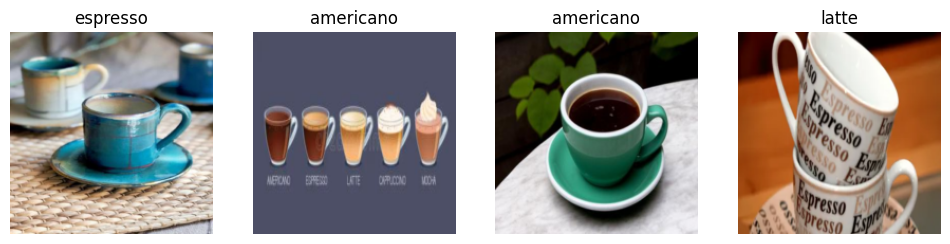

In [69]:
coffee = DataBlock(
    blocks=(ImageBlock, CategoryBlock),              # types for the independent and dependent variables
    get_items=get_image_files,                       # underlying items
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # random validation set
    get_y=parent_label,                              # get label from the name of the folder the file is in
    item_tfms=[Resize(192, method='squish')]         # images should have the same size
)

dls = coffee.dataloaders(path, bs=32)                # create DataLoaders from DataBlock, specifing the data source (path)
dls.valid.show_batch(max_n=4, nrows=1)

In [70]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.251516,2.159953,0.753247,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.558123,1.960684,0.636364,00:01
1,1.354953,2.276720,0.584416,00:01
2,1.165700,2.658017,0.597403,00:01
3,0.986861,2.783807,0.636364,00:01
4,0.849474,2.792351,0.636364,00:01


In [71]:
is_americano, _ ,probs = learn.predict(PILImage.create('../images/coffee americano.jpg'))
print(f"This is a: {is_americano}.")
print(f"Probability it's an americano: {probs[0]:.4f}")

This is a: americano.
Probability it's an americano: 0.9923


### Data Augmentation

**Data augmentation** refers to creating random variations of input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are:
- rotation
- flipping
- perspective warping
- brightness changes
- contrast changes

/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: De

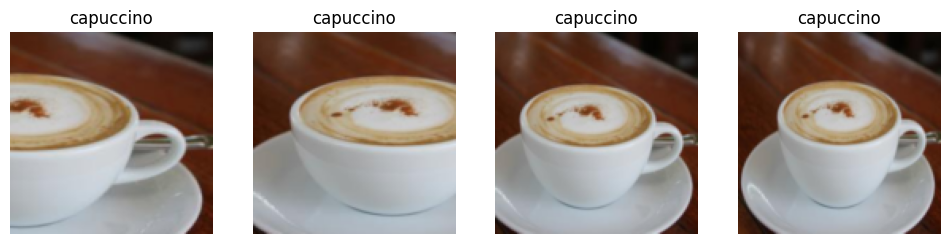

In [72]:
# Randomized Crop
coffee = coffee.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = coffee.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: De

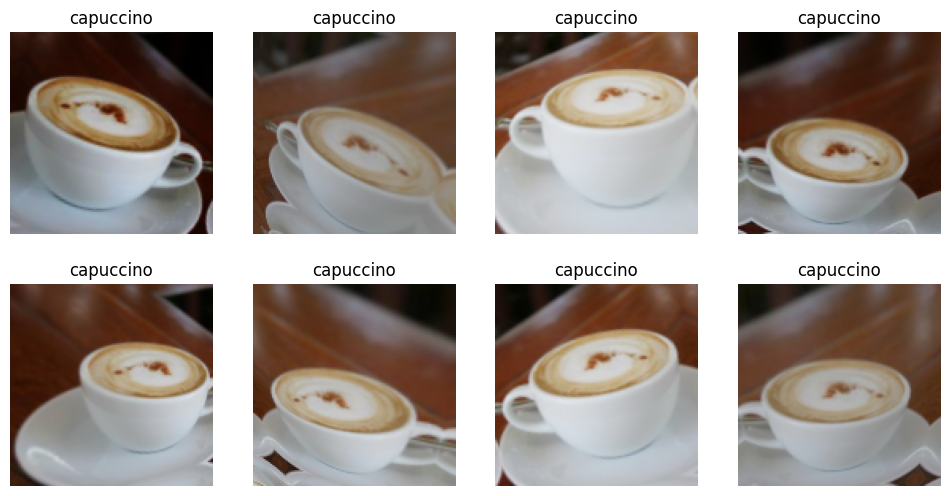

In [73]:
coffee = coffee.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = coffee.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [152]:
coffee = coffee.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = coffee.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.414943,1.019535,0.423077,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.483953,0.802071,0.346154,00:01
1,1.355642,0.531298,0.250000,00:01
2,1.121158,0.443198,0.192308,00:01
3,0.977224,0.425546,0.134615,00:01
4,0.870075,0.425566,0.134615,00:01


### Model Evaluation

**Confusion matrix**, calculated using the *validation set*.

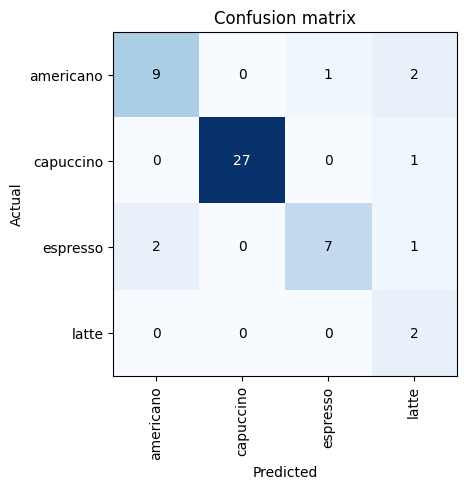

In [153]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**The loss** is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer.

/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:684: De

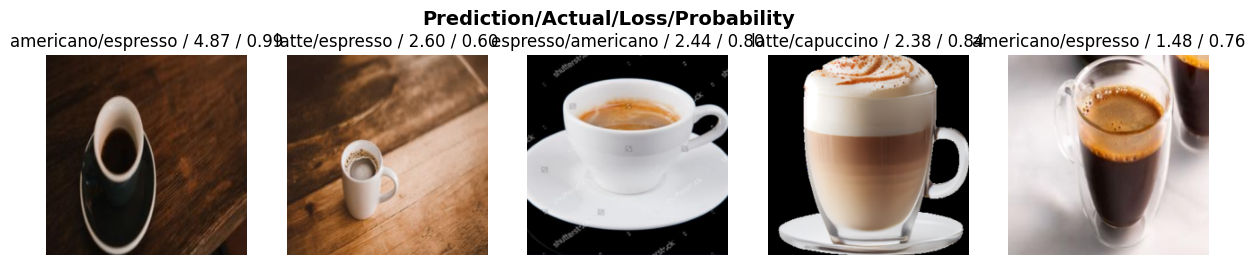

In [154]:
interp.plot_top_losses(5, nrows=1)

In [147]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/boris.tsarev/.pyenv/versions/3.12.9/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=83873) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


In [148]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turn Model into Application

### Save the Model

Save both architecture and trained parameters

In [163]:
learn.export('../../models/coffee.pkl')

When a model is used for getting predictions, instead of training, it's called *inference*.

In [164]:
learn_inf = load_learner('../../models/coffee.pkl')

/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [165]:
learn_inf.predict('../images/coffee americano.jpg')

('latte', tensor(3), tensor([3.1664e-01, 2.3157e-05, 6.8427e-03, 6.7650e-01]))

In [166]:
learn_inf.dls.vocab

['americano', 'capuccino', 'espresso', 'latte']

### Create the App

In [190]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

In [ ]:
# For the book, we can't actually click an upload button, so we fake it
# btn_upload = SimpleNamespace(data = ['../images/coffee capuccino.jpg'])

In [192]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [187]:
lbl_pred = widgets.Label()
lbl_pred

Label(value='')

In [185]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [191]:
VBox([widgets.Label('Select your coffee!'), 
      btn_upload, btn_run, out_pl, lbl_pred])